In [1]:
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain.agents.agent_types import AgentType
import subprocess
import os
import os
import json 
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableLambda, RunnableConfig
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
import subprocess
import os
import pandas as pd

In [2]:
# === LangGraph State ===
class AgentState(dict):
    """Holds state for LangGraph agent."""
    pass



In [3]:
# Shared memory
context = {
    "current_file": None,
    "current_test": None,
    "last_output": None
}

In [4]:
llm = ChatOpenAI(
    model="gpt-4o-mini",            # Use a lightweight GPT-4 model
    temperature=0,                  # Deterministic output (no randomness)
    api_key=os.environ["OPEN_AI_SECRET_KEY"]  # Pull your OpenAI key from environment
)

In [21]:
# ==========================================================
# === TOOLS ===
# ==========================================================



# === TOOL 1: Write a code file ===
@tool
def write_file_tool(input: dict) -> str:
    """Write Python code to a file."""
    file_path = input["file_path"]
    code = input["code"]

    # Remove markdown ```python or ``` wrappers if present
    code = re.sub(r"^```(?:python)?\\n", "", code.strip())
    code = re.sub(r"```$", "", code.strip())

    with open(file_path, "w") as f:
        f.write(code)
    return f"✅ Wrote file: {file_path}"

# === TOOL 2: Run tests using pytest ===
@tool
def run_pytest_tool(input: dict) -> str:
    """Run pytest on a file and return output."""
    file_path = input["file_path"]
    result = subprocess.run([
        "python", "-m", "pytest", file_path, "--disable-warnings", "-q"
    ], capture_output=True, text=True)
    return result.stdout + result.stderr

# === TOOL 3: Execute a Python script ===
@tool
def execute_script_tool(input: dict) -> str:
    """Execute a Python script and return output."""
    file_path = input["file_path"]
    result = subprocess.run(["python", file_path], capture_output=True, text=True)
    return result.stdout + result.stderr

tools = [write_file_tool, run_pytest_tool, execute_script_tool]

llm_with_tools = llm.bind_tools(tools)

query = "write a calculator"
result_gpt = llm_with_tools.invoke(query)

In [22]:
result_gpt.tool_calls

[{'name': 'write_file_tool',
  'args': {},
  'id': 'call_T93BI0g69OO8DSIXfp2eRrsd',
  'type': 'tool_call'}]

In [23]:
result_gpt.content

''

In [6]:
# ==========================================================
# === NODES ===
# ==========================================================

# === NODE 1: Plan the goal ===
def planner_node(state: AgentState):
    goal = state.get("input", "build a tool")
    return {"goal": goal}

# === NODE 2: Generate test file based on goal ===
def write_test_node(state: AgentState):
    goal = state.get("goal")
    prompt = f"""
Write a Python test file using pytest that validates the functionality of a tool based on this goal:
"{goal}"
Only output the code. Use a descriptive file name like test_<something>.py.
"""
    test_code = llm.invoke(prompt).content
    file_path = "test_tool.py"
    if "test_" in test_code:
        first_line = test_code.strip().split("\n")[0]
        if "test_" in first_line and ".py" in first_line:
            file_path = first_line.strip().replace("#", "").strip()
    write_file_tool.invoke({"file_path": file_path, "code": test_code})
    return {"test_file": file_path, "test_code": test_code}

# === NODE 3: Generate implementation that passes the test ===
def write_code_node(state: AgentState):
    test_code = state.get("test_code")
    prompt = f"""
Here is a Python test file written with pytest:

{test_code}

Write the Python implementation so that this test passes. Only return the code.
"""
    code = llm.invoke(prompt).content
    file_path = "tool.py"
    write_file_tool.invoke({"file_path": file_path, "code": code})
    return {"code_file": file_path, "code": code}

# === NODE 4: Run the generated test file ===
def run_test_node(state: AgentState):
    test_file = state.get("test_file", "test_tool.py")
    output = run_pytest_tool.invoke({"file_path": test_file})
    return {"test_output": output}

# === NODE 5: Generate and execute script using the tool ===
def run_script_node(state: AgentState):
    goal = state.get("goal")
    code = state.get("code")
    prompt = f"""
Here is a Python tool:

{code}

Write a short Python script that imports this tool and uses it to demonstrate its output.
Only return the script code.
"""
    script_code = llm.invoke(prompt).content
    file_path = "run_tool.py"
    write_file_tool.invoke({"file_path": file_path, "code": script_code})
    output = execute_script_tool.invoke({"file_path": file_path})
    return {"final_output": output}

In [12]:
# === Define the LangGraph ===
graph = StateGraph(AgentState)
graph.add_node("planner", RunnableLambda(planner_node))
# graph.add_node("write_test", RunnableLambda(write_test_node))
# graph.add_node("write_code", RunnableLambda(write_code_node))
# graph.add_node("run_tests", RunnableLambda(run_test_node))
# graph.add_node("execute", RunnableLambda(run_script_node))

# Edges (linear for now)
graph.set_entry_point("planner")
# graph.add_edge("planner", "write_test")
# graph.add_edge("write_test", "write_code")
# graph.add_edge("write_code", "run_tests")
# graph.add_edge("run_tests", "execute")
graph.add_edge("planner", END)

# # Compile the graph
app = graph.compile()

# from IPython.display import Image, display

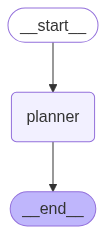

In [15]:
from IPython.display import Image, display

try:
    display(Image(data=app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")


In [14]:
# Run it
input_state = {"input": "create a calculator"}
final_state = app.invoke(input_state)
print("\n✅ FINAL OUTPUT:\n")
print(final_state)


✅ FINAL OUTPUT:

None
